# **Problem Statement**
## **Predicting Coupon Redemption**
XYZ Credit Card company regularly helps it’s merchants understand their data better and take key business decisions accurately by providing machine learning and analytics consulting. ABC is an established Brick & Mortar retailer that frequently conducts marketing campaigns for its diverse product range. As a merchant of XYZ, they have sought XYZ to assist them in their discount marketing process using the power of machine learning. Can you wear the AmExpert hat and help out ABC?

 
Discount marketing and coupon usage are very widely used promotional techniques to attract new customers and to retain & reinforce loyalty of existing customers. The measurement of a consumer’s propensity towards coupon usage and the prediction of the redemption behaviour are crucial parameters in assessing the effectiveness of a marketing campaign.

 
ABC’s promotions are shared across various channels including email, notifications, etc. A number of these campaigns include coupon discounts that are offered for a specific product/range of products. The retailer would like the ability to predict whether customers redeem the coupons received across channels, which will enable the retailer’s marketing team to accurately design coupon construct, and develop more precise and targeted marketing strategies.

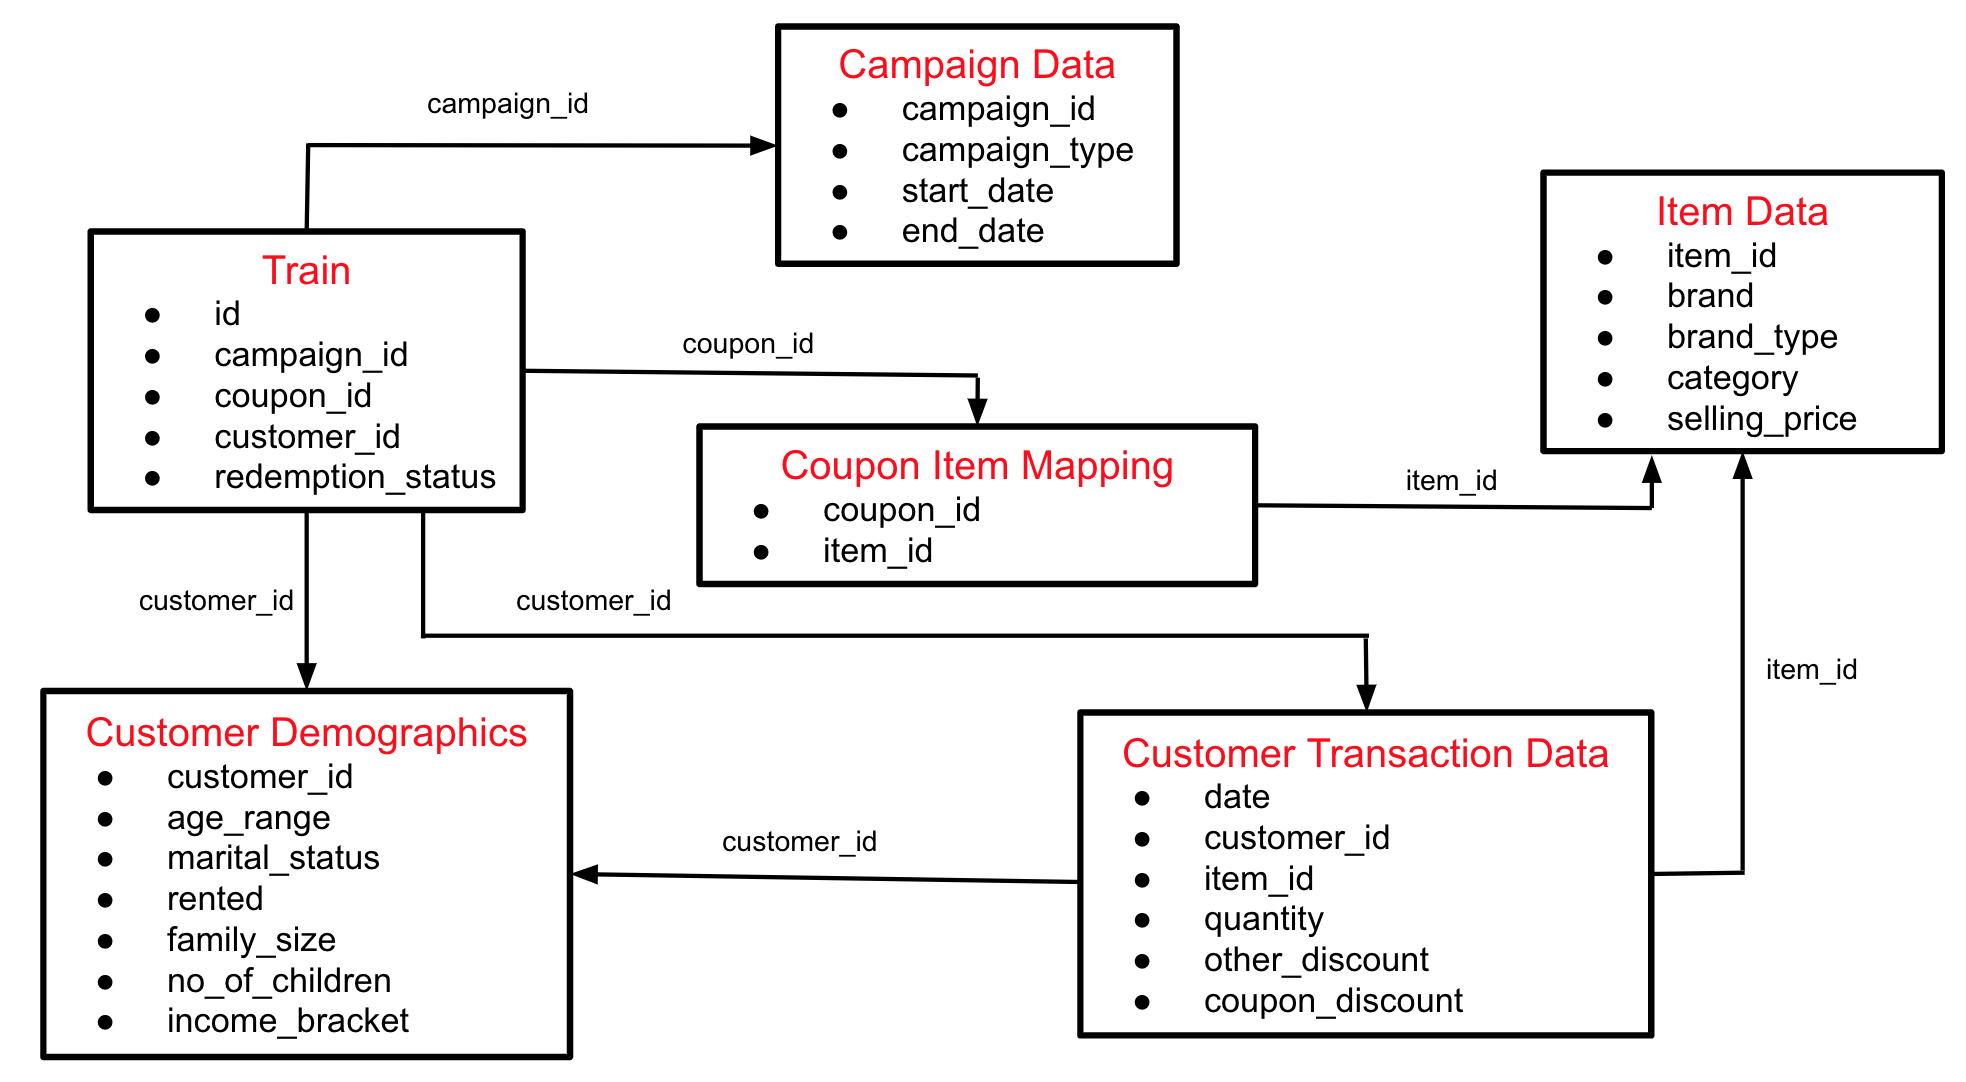

# **Importing Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mode
from sklearn import metrics, preprocessing, model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from collections import defaultdict, Counter
import lightgbm as lgb
import matplotlib.pyplot as plt

# **Reading Data**

In [2]:
train_data = pd.read_csv('../input/amexpert-2019/train.csv')
campaign_data = pd.read_csv('../input/amexpert-2019/campaign_data.csv')
item_data = pd.read_csv('../input/amexpert-2019/item_data.csv')
coupon_item_data = pd.read_csv('../input/amexpert-2019/coupon_item_mapping.csv')
customer_demog_data = pd.read_csv('../input/amexpert-2019/customer_demographics.csv')
transaction_data = pd.read_csv('../input/amexpert-2019/customer_transaction_data.csv')
test_data = pd.read_csv('../input/amexpert-2019/test_data.csv')

## **Campaign Data**

In [3]:
campaign_data['start_date'] = pd.to_datetime(campaign_data['start_date'], dayfirst = True)
campaign_data['end_date'] = pd.to_datetime(campaign_data['end_date'], dayfirst = True)
dummy_campaign_type = pd.get_dummies(campaign_data['campaign_type'], prefix = 'campaign_type')
campaign_data = pd.concat([campaign_data, dummy_campaign_type], axis = 1)
campaign_data

,campaign_id,campaign_type,start_date,end_date,campaign_type_X,campaign_type_Y
0,24,Y,2013-10-21,2013-12-20,0,1
1,25,Y,2013-10-21,2013-11-22,0,1
2,20,Y,2013-09-07,2013-11-16,0,1
3,23,Y,2013-10-08,2013-11-15,0,1
4,21,Y,2013-09-16,2013-10-18,0,1
5,22,X,2013-09-16,2013-10-18,1,0
6,18,X,2013-08-10,2013-10-04,1,0
7,19,Y,2013-08-26,2013-09-27,0,1
8,17,Y,2013-07-29,2013-08-30,0,1
9,16,Y,2013-07-15,2013-08-16,0,1


In [4]:
campaign_data['start_month'] = campaign_data['start_date'].dt.month
campaign_data['end_month'] = campaign_data['end_date'].dt.month
campaign_data['start_weekday'] = campaign_data['start_date'].dt.weekday
campaign_data['end_weekday'] = campaign_data['end_date'].dt.weekday
campaign_data['campaign_duration'] = (campaign_data['end_date'] - campaign_data['start_date'])/np.timedelta64(1,'D')

weekday_count = []
for i in range(0, campaign_data.shape[0]):
    weekdays = len((pd.bdate_range(start = campaign_data['start_date'][i], end = campaign_data['end_date'][i], freq = 'B')).tolist())
    weekday_count.append(weekdays)
campaign_data['weekdays_count'] = weekday_count

start_month = pd.get_dummies(campaign_data['start_month'], prefix = 'start_month')
end_month = pd.get_dummies(campaign_data['end_month'], prefix = 'end_month')
start_weekday = pd.get_dummies(campaign_data['start_weekday'], prefix = 'start_weekday')
end_weekday = pd.get_dummies(campaign_data['end_weekday'], prefix = 'end_weekday')
campaign_data = pd.concat([campaign_data,start_month, end_month, start_weekday, end_weekday], axis = 1)

campaign_data.drop(['start_month','end_month','start_weekday', 'end_weekday'], axis = 1, inplace = True)
campaign_data

,campaign_id,campaign_type,start_date,end_date,campaign_type_X,campaign_type_Y,campaign_duration,weekdays_count,start_month_1,start_month_2,...,end_month_10,end_month_11,end_month_12,start_weekday_0,start_weekday_1,start_weekday_2,start_weekday_5,start_weekday_6,end_weekday_4,end_weekday_5
0,24,Y,2013-10-21,2013-12-20,0,1,60.0,45,0,0,...,0,0,1,1,0,0,0,0,1,0
1,25,Y,2013-10-21,2013-11-22,0,1,32.0,25,0,0,...,0,1,0,1,0,0,0,0,1,0
2,20,Y,2013-09-07,2013-11-16,0,1,70.0,50,0,0,...,0,1,0,0,0,0,1,0,0,1
3,23,Y,2013-10-08,2013-11-15,0,1,38.0,29,0,0,...,0,1,0,0,1,0,0,0,1,0
4,21,Y,2013-09-16,2013-10-18,0,1,32.0,25,0,0,...,1,0,0,1,0,0,0,0,1,0
5,22,X,2013-09-16,2013-10-18,1,0,32.0,25,0,0,...,1,0,0,1,0,0,0,0,1,0
6,18,X,2013-08-10,2013-10-04,1,0,55.0,40,0,0,...,1,0,0,0,0,0,1,0,1,0
7,19,Y,2013-08-26,2013-09-27,0,1,32.0,25,0,0,...,0,0,0,1,0,0,0,0,1,0
8,17,Y,2013-07-29,2013-08-30,0,1,32.0,25,0,0,...,0,0,0,1,0,0,0,0,1,0
9,16,Y,2013-07-15,2013-08-16,0,1,32.0,25,0,0,...,0,0,0,1,0,0,0,0,1,0


In [5]:
campaign_data.columns

Index(['campaign_id', 'campaign_type', 'start_date', 'end_date',
       'campaign_type_X', 'campaign_type_Y', 'campaign_duration',
       'weekdays_count', 'start_month_1', 'start_month_2', 'start_month_3',
       'start_month_4', 'start_month_5', 'start_month_7', 'start_month_8',
       'start_month_9', 'start_month_10', 'start_month_11', 'start_month_12',
       'end_month_1', 'end_month_2', 'end_month_3', 'end_month_4',
       'end_month_5', 'end_month_6', 'end_month_7', 'end_month_8',
       'end_month_9', 'end_month_10', 'end_month_11', 'end_month_12',
       'start_weekday_0', 'start_weekday_1', 'start_weekday_2',
       'start_weekday_5', 'start_weekday_6', 'end_weekday_4', 'end_weekday_5'],
      dtype='object')

In [6]:
len((pd.bdate_range(start = campaign_data['start_date'][1], end = campaign_data['end_date'][1], freq = 'B')).tolist())

25

In [7]:
campaign_data_2 = campaign_data.add_suffix('_2')
campaign_data['key'] = 1
campaign_data_2['key'] = 1
campaign_data_3 = pd.merge(campaign_data, campaign_data_2, on = 'key', how = 'outer')
campaign_data_4 = campaign_data_3[(campaign_data_3.start_date_2 <= campaign_data_3.end_date) & (campaign_data_3.start_date <= campaign_data_3.end_date_2) 
                                  & (campaign_data_3.campaign_id != campaign_data_3.campaign_id_2)]

overlap_camp_count = campaign_data_4.groupby(['campaign_id'], as_index = False).campaign_id_2.count()
overlap_camp_count.columns = ['campaign_id', 'total_count']
overlap_X_camp_count = campaign_data_4[campaign_data_4.campaign_type_2 == 'X'].groupby(['campaign_id'], as_index = False).campaign_id_2.count()
overlap_X_camp_count.columns = ['campaign_id', 'total_X_count']
overlap_Y_camp_count = campaign_data_4[campaign_data_4.campaign_type_2 == 'Y'].groupby(['campaign_id'], as_index = False).campaign_id_2.count()
overlap_Y_camp_count.columns = ['campaign_id', 'total_Y_count']

campaign_data_5 = pd.merge(campaign_data, overlap_camp_count, on = 'campaign_id', how = 'left')
campaign_data_5 = pd.merge(campaign_data_5, overlap_X_camp_count, on = 'campaign_id', how = 'left')
campaign_data_5 = pd.merge(campaign_data_5, overlap_Y_camp_count, on = 'campaign_id', how = 'left')
campaign_data_5.fillna(0, inplace=True)
campaign_data_5.drop(['key'], axis = 1, inplace=True)
campaign_data_6 = campaign_data_5.drop(['campaign_type','start_date','end_date'], axis = 1)
campaign_data_6

,campaign_id,campaign_type_X,campaign_type_Y,campaign_duration,weekdays_count,start_month_1,start_month_2,start_month_3,start_month_4,start_month_5,...,start_weekday_0,start_weekday_1,start_weekday_2,start_weekday_5,start_weekday_6,end_weekday_4,end_weekday_5,total_count,total_X_count,total_Y_count
0,24,0,1,60.0,45,0,0,0,0,0,...,1,0,0,0,0,1,0,3,0.0,3
1,25,0,1,32.0,25,0,0,0,0,0,...,1,0,0,0,0,1,0,3,0.0,3
2,20,0,1,70.0,50,0,0,0,0,0,...,0,0,0,1,0,0,1,7,2.0,5
3,23,0,1,38.0,29,0,0,0,0,0,...,0,1,0,0,0,1,0,5,1.0,4
4,21,0,1,32.0,25,0,0,0,0,0,...,1,0,0,0,0,1,0,5,2.0,3
5,22,1,0,32.0,25,0,0,0,0,0,...,1,0,0,0,0,1,0,5,1.0,4
6,18,1,0,55.0,40,0,0,0,0,0,...,0,0,0,1,0,1,0,6,1.0,5
7,19,0,1,32.0,25,0,0,0,0,0,...,1,0,0,0,0,1,0,5,2.0,3
8,17,0,1,32.0,25,0,0,0,0,0,...,1,0,0,0,0,1,0,3,1.0,2
9,16,0,1,32.0,25,0,0,0,0,0,...,1,0,0,0,0,1,0,2,1.0,1


## **Coupon Item Mapping Data**

In [8]:
item_count = coupon_item_data.groupby(['coupon_id'], as_index = False).count()
item_count.columns = ['coupon_id', 'count_item']
coupon_count = coupon_item_data.groupby(['item_id']).coupon_id.count()
coupon_count.columns = ['item_id', 'count_coupon']
coupon_item_data_2 = pd.merge(coupon_item_data, item_count, on = 'coupon_id', how = 'left')
coupon_item_data_2 = pd.merge(coupon_item_data_2, coupon_count, on = 'item_id', how = 'left')
coupon_item_data_2.quantile([0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1])
coupon_item_data_2.columns = ['coupon_id', 'item_id', 'count_item', 'count_coupon']
coupon_item_data_2                              

,coupon_id,item_id,count_item,count_coupon
0,105,37,17,4
1,107,75,38,5
2,494,76,35,4
3,522,77,91,7
4,518,77,70,7
...,...,...,...,...
92658,32,69268,11814,3
92659,32,68502,11814,2
92660,32,68612,11814,2
92661,33,71390,4394,3


## **Item Data**

In [9]:
dummy_brand_type = pd.get_dummies(item_data.brand_type, prefix = 'brand')
dummy_category = pd.get_dummies(item_data.category, prefix = 'cat')
item_data_2 = pd.concat([item_data, dummy_brand_type, dummy_category], axis = 1)
item_data_2

,item_id,brand,brand_type,category,brand_Established,brand_Local,cat_Alcohol,cat_Bakery,"cat_Dairy, Juices & Snacks",cat_Flowers & Plants,...,cat_Natural Products,cat_Packaged Meat,cat_Pharmaceutical,cat_Prepared Food,cat_Restauarant,cat_Salads,cat_Seafood,cat_Skin & Hair Care,cat_Travel,cat_Vegetables (cut)
0,1,1,Established,Grocery,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,Established,Miscellaneous,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,56,Local,Bakery,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,56,Local,Grocery,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,56,Local,Grocery,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74061,74062,5490,Established,Pharmaceutical,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
74062,74063,5497,Established,Pharmaceutical,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
74063,74064,5497,Established,Pharmaceutical,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
74064,74065,5520,Established,Pharmaceutical,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


try merging item data on coupon data to summarise types of brands and categories at coupon level

## **Coupon Item Data 2**

In [10]:
coupon_item_temp = pd.merge(coupon_item_data_2[['coupon_id','item_id']], item_data_2, on = 'item_id', how = 'left')
cat_cols = [col for col in coupon_item_temp if col.startswith('cat_')]

coupon_item_temp_agg = coupon_item_temp.groupby('coupon_id', as_index = False).agg({'brand_Established' : 'sum'})
coupon_item_temp_agg.columns = ['coupon_id_coupon_', 'coupon_brand_Established_count']

for col in cat_cols:
    coupon_item_temp_agg_subset = coupon_item_temp.groupby('coupon_id', as_index = False).agg({col : ['sum']})
    coupon_item_temp_agg_subset.columns = ["_coupon_".join(y) for y in coupon_item_temp_agg_subset.columns.ravel()]
    coupon_item_temp_agg = pd.merge(coupon_item_temp_agg, coupon_item_temp_agg_subset, on = ['coupon_id_coupon_'], how = 'left')
    print(col)
    
coupon_item_temp_agg.rename(columns = {"coupon_id_coupon_" : "coupon_id"}, inplace = True)
coupon_item_temp_agg

cat_Alcohol
cat_Bakery
cat_Dairy, Juices & Snacks
cat_Flowers & Plants
cat_Fuel
cat_Garden
cat_Grocery
cat_Meat
cat_Miscellaneous
cat_Natural Products
cat_Packaged Meat
cat_Pharmaceutical
cat_Prepared Food
cat_Restauarant
cat_Salads
cat_Seafood
cat_Skin & Hair Care
cat_Travel
cat_Vegetables (cut)


,coupon_id,coupon_brand_Established_count,cat_Alcohol_coupon_sum,cat_Bakery_coupon_sum,"cat_Dairy, Juices & Snacks_coupon_sum",cat_Flowers & Plants_coupon_sum,cat_Fuel_coupon_sum,cat_Garden_coupon_sum,cat_Grocery_coupon_sum,cat_Meat_coupon_sum,...,cat_Natural Products_coupon_sum,cat_Packaged Meat_coupon_sum,cat_Pharmaceutical_coupon_sum,cat_Prepared Food_coupon_sum,cat_Restauarant_coupon_sum,cat_Salads_coupon_sum,cat_Seafood_coupon_sum,cat_Skin & Hair Care_coupon_sum,cat_Travel_coupon_sum,cat_Vegetables (cut)_coupon_sum
0,1,39.0,0,0,0.0,0.0,0,0,9.0,0.0,...,30.0,0.0,0.0,0,0,0,0.0,0.0,0,0
1,2,2.0,0,0,0.0,0.0,0,0,2.0,0.0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
2,3,17.0,0,0,0.0,0.0,0,0,17.0,0.0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
3,4,24.0,0,0,0.0,0.0,0,0,24.0,0.0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
4,5,7.0,0,0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,7.0,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,1112,6.0,0,0,0.0,0.0,0,0,6.0,0.0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
1112,1113,15.0,0,0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,15.0,0,0,0,0.0,0.0,0,0
1113,1114,3.0,0,0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,3.0,0,0,0,0.0,0.0,0,0
1114,1115,7.0,0,0,0.0,0.0,0,0,7.0,0.0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0


In [11]:
"coupon".join(col)

'ccouponacoupontcoupon_couponVcouponecoupongcouponecoupontcouponacouponbcouponlcouponecouponscoupon coupon(couponccouponucoupontcoupon)'

In [12]:
coupon_item_data_2 = pd.merge(coupon_item_data_2, coupon_item_temp_agg, on = 'coupon_id', how = 'left')
coupon_item_data_2

,coupon_id,item_id,count_item,count_coupon,coupon_brand_Established_count,cat_Alcohol_coupon_sum,cat_Bakery_coupon_sum,"cat_Dairy, Juices & Snacks_coupon_sum",cat_Flowers & Plants_coupon_sum,cat_Fuel_coupon_sum,...,cat_Natural Products_coupon_sum,cat_Packaged Meat_coupon_sum,cat_Pharmaceutical_coupon_sum,cat_Prepared Food_coupon_sum,cat_Restauarant_coupon_sum,cat_Salads_coupon_sum,cat_Seafood_coupon_sum,cat_Skin & Hair Care_coupon_sum,cat_Travel_coupon_sum,cat_Vegetables (cut)_coupon_sum
0,105,37,17,4,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
1,107,75,38,5,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
2,494,76,35,4,35.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
3,522,77,91,7,91.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
4,518,77,70,7,70.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92658,32,69268,11814,3,10745.0,0,0,3.0,0.0,0,...,0.0,0.0,9616.0,0,0,0,0.0,2170.0,0,0
92659,32,68502,11814,2,10745.0,0,0,3.0,0.0,0,...,0.0,0.0,9616.0,0,0,0,0.0,2170.0,0,0
92660,32,68612,11814,2,10745.0,0,0,3.0,0.0,0,...,0.0,0.0,9616.0,0,0,0,0.0,2170.0,0,0
92661,33,71390,4394,3,3897.0,0,0,0.0,0.0,0,...,0.0,1677.0,0.0,4,0,1,590.0,0.0,0,0


In [13]:
coupon_item_data_3 = pd.merge(coupon_item_temp_agg, coupon_item_data_2[['coupon_id','count_item']], on = 'coupon_id', how = 'left')
coupon_item_data_3.drop_duplicates(inplace = True)
coupon_item_data_3

,coupon_id,coupon_brand_Established_count,cat_Alcohol_coupon_sum,cat_Bakery_coupon_sum,"cat_Dairy, Juices & Snacks_coupon_sum",cat_Flowers & Plants_coupon_sum,cat_Fuel_coupon_sum,cat_Garden_coupon_sum,cat_Grocery_coupon_sum,cat_Meat_coupon_sum,...,cat_Packaged Meat_coupon_sum,cat_Pharmaceutical_coupon_sum,cat_Prepared Food_coupon_sum,cat_Restauarant_coupon_sum,cat_Salads_coupon_sum,cat_Seafood_coupon_sum,cat_Skin & Hair Care_coupon_sum,cat_Travel_coupon_sum,cat_Vegetables (cut)_coupon_sum,count_item
0,1,39.0,0,0,0.0,0.0,0,0,9.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,39
39,2,2.0,0,0,0.0,0.0,0,0,2.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,2
41,3,17.0,0,0,0.0,0.0,0,0,17.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,17
58,4,24.0,0,0,0.0,0.0,0,0,24.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,24
82,5,7.0,0,0,0.0,0.0,0,0,0.0,0.0,...,0.0,7.0,0,0,0,0.0,0.0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92630,1112,6.0,0,0,0.0,0.0,0,0,6.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,6
92636,1113,15.0,0,0,0.0,0.0,0,0,0.0,0.0,...,0.0,15.0,0,0,0,0.0,0.0,0,0,15
92651,1114,3.0,0,0,0.0,0.0,0,0,0.0,0.0,...,0.0,3.0,0,0,0,0.0,0.0,0,0,3
92654,1115,7.0,0,0,0.0,0.0,0,0,7.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,7


## **Customer Demog Data**

In [14]:
dummy_age = pd.get_dummies(customer_demog_data.age_range, prefix = 'age')
dummy_marital_status = pd.get_dummies(customer_demog_data.marital_status)
dummy_family_size = pd.get_dummies(customer_demog_data.family_size, prefix = 'family')
dummy_no_of_children = pd.get_dummies(customer_demog_data.no_of_children, prefix = 'children')
customer_demog_data_2 = pd.concat([customer_demog_data, dummy_age, dummy_marital_status, dummy_family_size, dummy_no_of_children], axis = 1)
customer_demog_data_2.drop(['age_range','marital_status','family_size','no_of_children'], axis = 1, inplace = True)
customer_demog_data_2['demog_not_missing'] = 1
customer_demog_data_2

,customer_id,rented,income_bracket,age_18-25,age_26-35,age_36-45,age_46-55,age_56-70,age_70+,Married,Single,family_1,family_2,family_3,family_4,family_5+,children_1,children_2,children_3+,demog_not_missing
0,1,0,4,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1
1,6,0,5,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
2,7,0,3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
3,8,0,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
4,10,0,5,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1577,0,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
756,1578,0,6,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
757,1579,0,4,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
758,1580,0,5,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## **Transaction Data**

In [15]:
from scipy import stats
transaction_data.describe(include = 'all')

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
count,1324566,1.324566e+06,1.324566e+06,1.324566e+06,1.324566e+06,1.324566e+06,1.324566e+06
unique,549,NaN,NaN,NaN,NaN,NaN,NaN
top,2012-09-03,NaN,NaN,NaN,NaN,NaN,NaN
freq,4753,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.040020e+02,2.951903e+04,1.306633e+02,1.146036e+02,-1.776871e+01,-5.948983e-01
std,NaN,4.573363e+02,1.790806e+04,1.311545e+03,1.529053e+02,3.788867e+01,7.069367e+00
min,NaN,1.000000e+00,1.000000e+00,1.000000e+00,3.600000e-01,-3.120310e+03,-1.992230e+03
25%,NaN,4.180000e+02,1.468400e+04,1.000000e+00,4.916000e+01,-2.315000e+01,0.000000e+00
50%,NaN,8.010000e+02,2.659700e+04,1.000000e+00,7.801000e+01,-1.780000e+00,0.000000e+00
75%,NaN,1.198000e+03,4.240575e+04,1.000000e+00,1.243100e+02,0.000000e+00,0.000000e+00


In [16]:
print(sum(np.abs(stats.zscore(transaction_data['quantity'])) < 3))
print(sum(np.abs(stats.zscore(transaction_data['selling_price'])) < 3))
print(sum(np.abs(stats.zscore(transaction_data['other_discount'])) < 3))
print(sum(np.abs(stats.zscore(transaction_data['coupon_discount'])) < 3))

1310299
1303194
1304616
1312383


In [17]:
transaction_data[np.abs(stats.zscore(transaction_data['quantity'])) < 3]

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0
...,...,...,...,...,...,...,...
1324561,2013-06-30,1129,2777,1,284.60,-71.24,0.0
1324562,2013-06-30,1129,2953,4,42.74,-28.50,0.0
1324563,2013-06-30,1129,2971,6,64.12,-42.74,0.0
1324564,2013-06-30,1129,46984,1,95.82,0.00,0.0


In [18]:
#removing outliers from quantity, selling_price and discounts columns
temp = transaction_data[(np.abs(stats.zscore(transaction_data['selling_price'])) < 3)]
temp = temp[(np.abs(stats.zscore(temp['other_discount'])) < 3)]
temp = temp[(np.abs(stats.zscore(temp['coupon_discount'])) < 3)]
temp = temp[(np.abs(stats.zscore(temp['quantity'])) < 2)]
temp.describe(include = 'all')

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
count,1261652,1.261652e+06,1.261652e+06,1.261652e+06,1.261652e+06,1.261652e+06,1.261652e+06
unique,549,NaN,NaN,NaN,NaN,NaN,NaN
top,2012-09-03,NaN,NaN,NaN,NaN,NaN,NaN
freq,4559,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.035825e+02,2.912386e+04,1.277192e+00,9.623892e+01,-1.409649e+01,-3.192043e-02
std,NaN,4.568160e+02,1.779314e+04,1.250076e+00,7.462889e+01,2.191767e+01,6.277268e-01
min,NaN,1.000000e+00,1.000000e+00,1.000000e+00,3.600000e-01,-1.161200e+02,-1.603000e+01
25%,NaN,4.180000e+02,1.453000e+04,1.000000e+00,4.737000e+01,-2.102000e+01,0.000000e+00
50%,NaN,8.010000e+02,2.613900e+04,1.000000e+00,7.124000e+01,0.000000e+00,0.000000e+00
75%,NaN,1.195000e+03,3.705425e+04,1.000000e+00,1.171900e+02,0.000000e+00,0.000000e+00


In [19]:
transaction_data_1 = temp
transaction_data_1.date = pd.to_datetime(transaction_data_1.date)

In [20]:
transaction_data_2 = pd.merge(transaction_data_1, coupon_item_data_2[['item_id','count_coupon']], on = 'item_id', how = 'left')
transaction_data_2 = pd.merge(transaction_data_2, item_data_2, on = 'item_id', how = 'left')
transaction_data_2['key'] = 1
campaign_data_5['key'] = 1
transaction_data_2


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,count_coupon,brand,brand_type,...,cat_Packaged Meat,cat_Pharmaceutical,cat_Prepared Food,cat_Restauarant,cat_Salads,cat_Seafood,cat_Skin & Hair Care,cat_Travel,cat_Vegetables (cut),key
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,1
1,2012-01-02,1501,26830,1,35.26,-10.69,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,1
2,2012-01-02,1501,26830,1,35.26,-10.69,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,1
3,2012-01-02,1501,54253,1,53.43,-13.89,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,1
4,2012-01-02,1501,54253,1,53.43,-13.89,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534007,2013-06-30,1129,2971,6,64.12,-42.74,0.0,NaN,56,Local,...,0,0,0,0,0,0,0,0,0,1
2534008,2013-06-30,1129,46984,1,95.82,0.00,0.0,1.0,56,Local,...,0,0,0,0,0,0,0,0,0,1
2534009,2013-06-30,1129,64498,2,489.78,0.00,0.0,3.0,3514,Established,...,0,0,0,0,0,0,0,0,0,1
2534010,2013-06-30,1129,64498,2,489.78,0.00,0.0,3.0,3514,Established,...,0,0,0,0,0,0,0,0,0,1


In [21]:
max(transaction_data_2.date)

Timestamp('2013-07-03 00:00:00')

In [22]:
min(transaction_data_2.date)

Timestamp('2012-01-02 00:00:00')

In [23]:
cust_item_count = transaction_data_2.groupby(['customer_id'], as_index = False).agg({'item_id' : 'count'})
cust_item_count.columns = ['customer_id', 'item_count']

cust_other_discount_avail = transaction_data_2[transaction_data_2['other_discount'] < 0].groupby(['customer_id'], as_index = False).agg({'other_discount' : 'count'})
cust_other_discount_avail.columns = ['customer_id','other_disc_avail_cnt']

cust_discount_avail = transaction_data_2[transaction_data_2['coupon_discount'] < 0].groupby(['customer_id'], as_index = False).agg({'coupon_discount' : 'count'})
cust_discount_avail.columns = ['customer_id','coupon_disc_avail_cnt']

cust_item_count

,customer_id,item_count
0,1,2061
1,2,803
2,3,1235
3,4,441
4,5,1552
...,...,...
1577,1578,1589
1578,1579,2022
1579,1580,1202
1580,1581,965


In [24]:
transaction_data_2['day'] = transaction_data_2['date'].dt.day
transaction_data_2['week'] = transaction_data_2['date'].dt.week
transaction_data_2['month'] = transaction_data_2['date'].dt.month
transaction_data_2['week_day'] = transaction_data_2['date'].dt.weekday

weekday_dumm = pd.get_dummies(transaction_data_2['week_day'], prefix = 'week_day')
month_dumm = pd.get_dummies(transaction_data_2['month'], prefix = 'month')

transaction_data_2 = pd.concat([transaction_data_2, weekday_dumm, month_dumm], axis = 1) 
transaction_data_2

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,count_coupon,brand,brand_type,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-02,1501,26830,1,35.26,-10.69,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-02,1501,26830,1,35.26,-10.69,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-02,1501,54253,1,53.43,-13.89,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-02,1501,54253,1,53.43,-13.89,0.0,3.0,56,Local,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534007,2013-06-30,1129,2971,6,64.12,-42.74,0.0,NaN,56,Local,...,0,0,0,1,0,0,0,0,0,0
2534008,2013-06-30,1129,46984,1,95.82,0.00,0.0,1.0,56,Local,...,0,0,0,1,0,0,0,0,0,0
2534009,2013-06-30,1129,64498,2,489.78,0.00,0.0,3.0,3514,Established,...,0,0,0,1,0,0,0,0,0,0
2534010,2013-06-30,1129,64498,2,489.78,0.00,0.0,3.0,3514,Established,...,0,0,0,1,0,0,0,0,0,0


In [25]:
unique_days_active = transaction_data_2.groupby(['customer_id'], as_index = False).agg({'date' : 'nunique'})
unique_days_active.columns = ['customer_id', 'count_unique_days']
unique_days_active

,customer_id,count_unique_days
0,1,56
1,2,35
2,3,40
3,4,26
4,5,158
...,...,...
1577,1578,33
1578,1579,148
1579,1580,99
1580,1581,50


In [26]:
transaction_merge_data_2 = transaction_data_2.drop(['date', 'item_id', 'brand', 'key', 'brand_type', 'category'], axis = 1)
transaction_merge_data_2

,customer_id,quantity,selling_price,other_discount,coupon_discount,count_coupon,brand_Established,brand_Local,cat_Alcohol,cat_Bakery,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1501,1,35.26,-10.69,0.0,3.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1501,1,35.26,-10.69,0.0,3.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1501,1,35.26,-10.69,0.0,3.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1501,1,53.43,-13.89,0.0,3.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1501,1,53.43,-13.89,0.0,3.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534007,1129,6,64.12,-42.74,0.0,NaN,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2534008,1129,1,95.82,0.00,0.0,1.0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2534009,1129,2,489.78,0.00,0.0,3.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2534010,1129,2,489.78,0.00,0.0,3.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


remove ou

In [27]:
# agg_cols_1 = ['quantity', 'selling_price', 'other_discount', 'coupon_discount','count_item']
# brand_cols = [col for col in transaction_merge_data_2 if col.startswith('brand')]
# cat_cols = [col for col in transaction_merge_data_2 if col.startswith('cat')]

# col_list = agg_cols_1 + brand_cols + cat_cols

# transaction_summary_sub = transaction_merge_data_2.groupby(['customer_id', 'coupon_id'], as_index = False).agg({'count_coupon' : ['sum', 'min', 'max','std','median','mean']})
# transaction_summary_sub.columns = ["_".join(x) for x in transaction_summary_sub.columns.ravel()]

# for col in col_list:
#     transaction_summary_subset = transaction_merge_data_2.groupby(['customer_id', 'coupon_id'], as_index = False).agg({col : ['sum', 'min', 'max','std','median','mean']})
#     transaction_summary_subset.columns = ["_".join(x) for x in transaction_summary_subset.columns.ravel()]
#     transaction_summary_sub = pd.merge(transaction_summary_sub, transaction_summary_subset, on = ['customer_id_', 'coupon_id_'], how = 'left')
#     print(col)
# transaction_summary_sub.rename(columns = {"customer_id_" : "customer_id", "coupon_id_" : "coupon_id"}, inplace = True)
# transaction_summary_sub['txn_not_missing'] = 1
# transaction_summary_sub.columns

In [28]:
agg_cols_1 = ['quantity', 'selling_price', 'other_discount', 'coupon_discount']
brand_cols = [col for col in transaction_merge_data_2 if col.startswith('brand')]
cat_cols = [col for col in transaction_merge_data_2 if col.startswith('cat')]
weekday_cols = [col for col in transaction_merge_data_2 if col.startswith('week_day_')]
month_cols = [col for col in transaction_merge_data_2 if col.startswith('month_')]

col_list = agg_cols_1 + brand_cols + cat_cols

transaction_summary_sub = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({'count_coupon' : ['min','max','mean']})
transaction_summary_sub.columns = ["_".join(x) for x in transaction_summary_sub.columns.ravel()]

for col in agg_cols_1:
    transaction_summary_subset = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({col : ['sum', 'min', 'max','std','mean']})
    transaction_summary_subset.columns = ["_".join(x) for x in transaction_summary_subset.columns.ravel()]
    transaction_summary_sub = pd.merge(transaction_summary_sub, transaction_summary_subset, on = ['customer_id_'], how = 'left')
    print(col)
    
for col in brand_cols:
    transaction_summary_subset = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({col : ['sum', 'mean']})
    transaction_summary_subset.columns = ["_".join(x) for x in transaction_summary_subset.columns.ravel()]
    transaction_summary_sub = pd.merge(transaction_summary_sub, transaction_summary_subset, on = ['customer_id_'], how = 'left')
    print(col)
    
for col in cat_cols:
    transaction_summary_subset = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({col : ['sum', 'mean']})
    transaction_summary_subset.columns = ["_".join(x) for x in transaction_summary_subset.columns.ravel()]
    transaction_summary_sub = pd.merge(transaction_summary_sub, transaction_summary_subset, on = ['customer_id_'], how = 'left')
    print(col)
    
for col in weekday_cols:
    transaction_summary_subset = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({col : ['sum']})
    transaction_summary_subset.columns = ["_".join(x) for x in transaction_summary_subset.columns.ravel()]
    transaction_summary_sub = pd.merge(transaction_summary_sub, transaction_summary_subset, on = ['customer_id_'], how = 'left')
    print(col)

for col in month_cols:
    transaction_summary_subset = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({col : ['sum']})
    transaction_summary_subset.columns = ["_".join(x) for x in transaction_summary_subset.columns.ravel()]
    transaction_summary_sub = pd.merge(transaction_summary_sub, transaction_summary_subset, on = ['customer_id_'], how = 'left')
    print(col)
    
# for col in year_cols:
#     transaction_summary_subset = transaction_merge_data_2.groupby(['customer_id', 'coupon_id'], as_index = False).agg({col : ['sum']})
#     transaction_summary_subset.columns = ["_".join(x) for x in transaction_summary_subset.columns.ravel()]
#     transaction_summary_sub = pd.merge(transaction_summary_sub, transaction_summary_subset, on = ['customer_id_', 'coupon_id_'], how = 'left')
#     print(col)
    
unique_weeks_active = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({'week' : 'nunique'})
unique_weeks_active.columns = ['customer_id', 'count_unique_weeks']

unique_week_days_active = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({'week_day' : 'nunique'})
unique_week_days_active.columns = ['customer_id', 'count_unique_week_days']

unique_months_active = transaction_merge_data_2.groupby(['customer_id'], as_index = False).agg({'month' : 'nunique'})
unique_months_active.columns = ['customer_id', 'count_unique_months']

# unique_years_active = transaction_merge_data_2.groupby(['customer_id', 'coupon_id'], as_index = False).agg({'year' : 'nunique'})
# unique_years_active.columns = ['customer_id', 'coupon_id', 'count_unique_years']

transaction_summary_sub.rename(columns = {"customer_id_" : "customer_id"}, inplace = True)
transaction_summary_sub['txn_not_missing'] = 1

transaction_summary_sub = pd.merge(transaction_summary_sub, unique_days_active, on = ['customer_id'], how = 'left')
transaction_summary_sub = pd.merge(transaction_summary_sub, unique_weeks_active, on = ['customer_id'], how = 'left')
transaction_summary_sub = pd.merge(transaction_summary_sub, unique_week_days_active, on = ['customer_id'], how = 'left')
transaction_summary_sub = pd.merge(transaction_summary_sub, unique_months_active, on = ['customer_id'], how = 'left')
# transaction_summary_sub = pd.merge(transaction_summary_sub, unique_years_active, on = ['customer_id', 'coupon_id'], how = 'left')

transaction_summary_sub.columns

quantity
selling_price
other_discount
coupon_discount
brand_Established
brand_Local
cat_Alcohol
cat_Bakery
cat_Dairy, Juices & Snacks
cat_Flowers & Plants
cat_Fuel
cat_Garden
cat_Grocery
cat_Meat
cat_Miscellaneous
cat_Natural Products
cat_Packaged Meat
cat_Pharmaceutical
cat_Prepared Food
cat_Restauarant
cat_Salads
cat_Seafood
cat_Skin & Hair Care
cat_Travel
cat_Vegetables (cut)
week_day_0
week_day_1
week_day_2
week_day_3
week_day_4
week_day_5
week_day_6
month_1
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
month_10
month_11
month_12


Index(['customer_id', 'count_coupon_min', 'count_coupon_max',
       'count_coupon_mean', 'quantity_sum', 'quantity_min', 'quantity_max',
       'quantity_std', 'quantity_mean', 'selling_price_sum',
       'selling_price_min', 'selling_price_max', 'selling_price_std',
       'selling_price_mean', 'other_discount_sum', 'other_discount_min',
       'other_discount_max', 'other_discount_std', 'other_discount_mean',
       'coupon_discount_sum', 'coupon_discount_min', 'coupon_discount_max',
       'coupon_discount_std', 'coupon_discount_mean', 'brand_Established_sum',
       'brand_Established_mean', 'brand_Local_sum', 'brand_Local_mean',
       'cat_Alcohol_sum', 'cat_Alcohol_mean', 'cat_Bakery_sum',
       'cat_Bakery_mean', 'cat_Dairy, Juices & Snacks_sum',
       'cat_Dairy, Juices & Snacks_mean', 'cat_Flowers & Plants_sum',
       'cat_Flowers & Plants_mean', 'cat_Fuel_sum', 'cat_Fuel_mean',
       'cat_Garden_sum', 'cat_Garden_mean', 'cat_Grocery_sum',
       'cat_Grocery_mean', 'cat

In [29]:
transaction_summary_sub = pd.merge(transaction_summary_sub, cust_item_count, on = ['customer_id'], how = 'left')
transaction_summary_sub = pd.merge(transaction_summary_sub, cust_discount_avail, on = ['customer_id'], how = 'left')
transaction_summary_sub = pd.merge(transaction_summary_sub, cust_other_discount_avail, on = ['customer_id'], how = 'left')

transaction_summary_sub['other_disc_avail_cnt'].fillna(0, inplace = True)
transaction_summary_sub['coupon_disc_avail_cnt'].fillna(0, inplace = True)

transaction_summary_sub

,customer_id,count_coupon_min,count_coupon_max,count_coupon_mean,quantity_sum,quantity_min,quantity_max,quantity_std,quantity_mean,selling_price_sum,...,month_11_sum,month_12_sum,txn_not_missing,count_unique_days,count_unique_weeks,count_unique_week_days,count_unique_months,item_count,coupon_disc_avail_cnt,other_disc_avail_cnt
0,1,1.0,10.0,4.771725,2259,1,5,0.343439,1.096070,184401.82,...,97.0,188.0,1,56,38,7,12,2061,55.0,1166
1,2,1.0,7.0,3.140888,885,1,5,0.389428,1.102117,80336.64,...,34.0,69.0,1,35,26,7,11,803,0.0,358
2,3,1.0,10.0,3.322105,1960,1,12,1.080771,1.587045,129465.95,...,71.0,64.0,1,40,30,7,12,1235,8.0,703
3,4,1.0,10.0,3.507042,555,1,4,0.548822,1.258503,56079.53,...,27.0,25.0,1,26,21,6,11,441,0.0,198
4,5,1.0,11.0,3.389937,2246,1,24,1.691879,1.447165,186998.75,...,139.0,133.0,1,158,51,7,12,1552,0.0,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,1578,1.0,8.0,3.432836,1960,1,7,0.507115,1.233480,133949.42,...,70.0,35.0,1,33,28,7,12,1589,24.0,741
1578,1579,1.0,10.0,3.014531,2833,1,12,0.898544,1.401088,235534.02,...,161.0,128.0,1,148,50,7,12,2022,0.0,1100
1579,1580,1.0,9.0,3.912351,1348,1,6,0.496672,1.121464,131840.19,...,230.0,77.0,1,99,43,7,12,1202,0.0,636
1580,1581,1.0,8.0,3.641161,1279,1,8,0.742758,1.325389,86496.44,...,5.0,6.0,1,50,32,7,12,965,0.0,553


try summarising the date info like purachses done in a month, week, recent purchase done etc at cust/(cust-coupon) level 

## **Train Data**

In [30]:
(train_data.groupby(['customer_id', 'campaign_id',  'coupon_id']).id.count()).quantile([0, 0.25, 0.5, 0.75, 0.99, 0.9998, 1])

0.0000    1.0
0.2500    1.0
0.5000    1.0
0.7500    1.0
0.9900    1.0
0.9998    1.0
1.0000    2.0
Name: id, dtype: float64

In [31]:
(train_data.groupby(['customer_id', 'coupon_id'], as_index = False).campaign_id.count())

,customer_id,coupon_id,campaign_id
0,1,3,1
1,1,24,1
2,1,52,1
3,1,63,1
4,1,75,1
...,...,...,...
77096,1582,1025,1
77097,1582,1043,1
77098,1582,1047,1
77099,1582,1070,1


In [32]:
train_data.redemption_status.value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [33]:
train_data.campaign_id.value_counts()

13    22606
8     22555
30     6467
26     6056
29     3895
9      3168
11     2782
12     2550
5      1827
10     1723
7      1584
4       972
2       768
28      476
3       408
27      324
1       143
6        65
Name: campaign_id, dtype: int64

In [34]:
train_data_2 = pd.merge(train_data, customer_demog_data_2, on = 'customer_id', how = 'left')
train_data_2 = pd.merge(train_data_2, campaign_data_6, on = 'campaign_id', how = 'left')
train_data_2 = pd.merge(train_data_2, transaction_summary_sub, on = ['customer_id'], how = 'left')
train_data_2 = pd.merge(train_data_2, coupon_item_data_3, on = 'coupon_id', how = 'left')

train_data_2['demog_not_missing'].fillna(0, inplace = True)
train_data_2['txn_not_missing'].fillna(0, inplace = True)
train_data_2

,id,campaign_id,coupon_id,customer_id,redemption_status,rented,income_bracket,age_18-25,age_26-35,age_36-45,...,cat_Packaged Meat_coupon_sum,cat_Pharmaceutical_coupon_sum,cat_Prepared Food_coupon_sum,cat_Restauarant_coupon_sum,cat_Salads_coupon_sum,cat_Seafood_coupon_sum,cat_Skin & Hair Care_coupon_sum,cat_Travel_coupon_sum,cat_Vegetables (cut)_coupon_sum,count_item
0,1,13,27,1053,0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,125
1,2,13,116,48,0,0.0,3.0,0.0,0.0,1.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,3
2,6,9,635,205,0,0.0,7.0,0.0,0.0,0.0,...,0.0,67.0,0,0,0,0.0,0.0,0,0,67
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,0.0,0,0,4
4,9,8,1017,1489,0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,128587,8,71,1523,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,4
78365,128589,30,547,937,0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,7
78366,128590,8,754,1004,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,0.0,0,0,83
78367,128592,13,134,71,0,0.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0,0,0,0.0,0.0,0,0,7


In [35]:
train_data_2[['demog_not_missing','txn_not_missing']]

,demog_not_missing,txn_not_missing
0,1.0,1
1,1.0,1
2,1.0,1
3,0.0,1
4,1.0,1
...,...,...
78364,1.0,1
78365,1.0,1
78366,0.0,1
78367,1.0,1


In [36]:
train_data_2.columns
train_data_2 = train_data_2.reset_index()

In [37]:
train_data_2.groupby(['demog_not_missing','txn_not_missing'], as_index = False)[['customer_id','coupon_id']].count()

,demog_not_missing,txn_not_missing,customer_id,coupon_id
0,0.0,1,34708,34708
1,1.0,1,43661,43661


## **Baseline Model**

In [38]:
train_data_X = train_data_2.drop(['index', 'id', 'campaign_id','customer_id','redemption_status','coupon_id'], axis = 1)
train_data_Y = train_data_2.redemption_status

from scipy import stats
X = train_data_X
y = train_data_Y


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer

# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# imp.fit(X)
# X1 = imp.transform(X)

from sklearn.preprocessing import StandardScaler, RobustScaler
sc = RobustScaler()
train_X = sc.fit_transform(X)

print(type(train_X))
X2 = train_X

<class 'numpy.ndarray'>


In [39]:
train_data_X.shape

(78369, 169)

In [40]:
# #logistic without oversampling
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.25, random_state = 2156)

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0, solver='saga',class_weight = 'balanced' ,multi_class='ovr',max_iter = 1000, C = 0.5,penalty = 'elasticnet', l1_ratio = 0.5).fit(X_train, y_train)
# pred = clf.predict(X_test) 

# from sklearn.metrics import roc_auc_score
# print(roc_auc_score(y_test, pred))

# from sklearn.metrics import classification_report
# print(classification_report(y_test,pred))

0.8710018027298481

In [41]:
# #svm without oversampling
# from sklearn.svm import SVC
# clf = SVC(gamma='auto').fit(X_train, y_train)
# pred = clf.predict(X_test) 
# print(roc_auc_score(y_test, pred))
# print(classification_report(y_test,pred))

In [42]:
# #logistic with oversampling
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 2156)
# X_r, y_r = sm.fit_resample(X2, y)
# X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size = 0.25, random_state = 2156)

# clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter = 100, C = 0.5).fit(X_train, y_train)
# pred = clf.predict(X_test) 

# from sklearn.metrics import roc_auc_score
# print(roc_auc_score(y_test, pred))

# from sklearn.metrics import classification_report
# print(classification_report(y_test,pred))

In [43]:
# #logistic wth borderline SMOTE
# from imblearn.over_sampling import BorderlineSMOTE
# X_r2, y_r2 = BorderlineSMOTE().fit_resample(X2, y)

# X_train, X_test, y_train, y_test = train_test_split(X_r2, y_r2, test_size = 0.25, random_state = 2156)

# clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter = 100, C = 0.5).fit(X_train, y_train)
# pred = clf.predict(X_test) 

# from sklearn.metrics import roc_auc_score
# print(roc_auc_score(y_test, pred))

# from sklearn.metrics import classification_report
# print(classification_report(y_test,pred))

In [44]:
# #ogistic with SMOTENC
# from imblearn.over_sampling import SMOTENC
# smote_nc = SMOTENC(categorical_features=[0, 2], random_state=0)
# X_r3, y_r3 = smote_nc.fit_resample(X2, y)

# X_train, X_test, y_train, y_test = train_test_split(X_r3, y_r3, test_size = 0.25, random_state = 2156)

# clf = LogisticRegression(random_state=0, solver='newton-cg',max_iter = 100, C = 0.5).fit(X_train, y_train)
# pred = clf.predict(X_test) 

# from sklearn.metrics import roc_auc_score
# print(roc_auc_score(y_test, pred))

# from sklearn.metrics import classification_report
# print(classification_report(y_test,pred))

In [45]:
# #logistic with SVM SMOTE
# from imblearn.over_sampling import SVMSMOTE
# X_r4, y_r4 = SVMSMOTE().fit_resample(X2, y)

# X_train, X_test, y_train, y_test = train_test_split(X_r4, y_r4, test_size = 0.25, random_state = 2156)

# clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter = 5000, C = 0.5, dual = False).fit(X_train, y_train)
# pred = clf.predict(X_test) 

# from sklearn.metrics import roc_auc_score
# print(roc_auc_score(y_test, pred))

# from sklearn.metrics import classification_report
# print(classification_report(y_test,pred))

In [46]:
# #logistic with Kmeans SMOTE
# from imblearn.over_sampling import KMeansSMOTE
# X_r5, y_r5 = KMeansSMOTE().fit_resample(X2, y)

# X_train, X_test, y_train, y_test = train_test_split(X_r5, y_r5, test_size = 0.25, random_state = 2156)

# clf = LogisticRegression(random_state=0, solver='newton-cg',max_iter = 100).fit(X_train, y_train)
# pred = clf.predict(X_test) 

# from sklearn.metrics import roc_auc_score
# print(roc_auc_score(y_test, pred))

# from sklearn.metrics import classification_report
# print(classification_report(y_test,pred))

In [47]:
# from imblearn.over_sampling import BorderlineSMOTE
# X_r2, y_r2 = BorderlineSMOTE().fit_resample(X2, y)
# from imblearn.over_sampling import SVMSMOTE
# X_r4, y_r4 = SVMSMOTE().fit_resample(X2, y)

In [48]:
corr_matrix = train_data_X.corr().abs()
corr_matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(high_cor))
print(high_cor)
features = [i for i in train_data_X.columns.tolist() if i not in high_cor]
print(len(features))
print(features)

19
['children_3+', 'campaign_type_Y', 'weekdays_count', 'end_month_7', 'end_month_9', 'end_weekday_5', 'brand_Local_mean', 'cat_Grocery_sum', 'item_count', 'coupon_disc_avail_cnt', 'other_disc_avail_cnt', 'cat_Garden_coupon_sum', 'cat_Natural Products_coupon_sum', 'cat_Packaged Meat_coupon_sum', 'cat_Salads_coupon_sum', 'cat_Skin & Hair Care_coupon_sum', 'cat_Travel_coupon_sum', 'cat_Vegetables (cut)_coupon_sum', 'count_item']
150
['rented', 'income_bracket', 'age_18-25', 'age_26-35', 'age_36-45', 'age_46-55', 'age_56-70', 'age_70+', 'Married', 'Single', 'family_1', 'family_2', 'family_3', 'family_4', 'family_5+', 'children_1', 'children_2', 'demog_not_missing', 'campaign_type_X', 'campaign_duration', 'start_month_1', 'start_month_2', 'start_month_3', 'start_month_4', 'start_month_5', 'start_month_7', 'start_month_8', 'start_month_9', 'start_month_10', 'start_month_11', 'start_month_12', 'end_month_1', 'end_month_2', 'end_month_3', 'end_month_4', 'end_month_5', 'end_month_6', 'end_mont

In [49]:
train_X = train_data_X[features]
X3 = sc.fit_transform(train_X)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size = 0.25, random_state = 2156)

In [51]:
#training on complete set using lightgbm
params = {}
params = {'bagging_fraction': 0.7152640724930646,
 'feature_fraction': 0.25413787367143803,
 'scale_pos_weight' : 3.5,
 'lambda_l1': 0.2,
 'lambda_l2': 4.5,
 'learning_rate': 0.017100687927855764,
 'max_bin': 45,
 'max_depth': 8,
 'min_data_in_leaf': 185,
 'min_split_gain': 0.0029471188319716633,
 'min_sum_hessian_in_leaf': 0.9222459426424153,
 'num_leaves': 30}
params["objective"] = "binary"
params['metric'] = 'auc'
# params['is_unbalance'] = 'true'
# params['max_bin'] = 20
params['random_state'] = 2156


# params['device'] = 'gpu'

num_rounds = 10000
plst = list(params.items())
lgtrain = lgb.Dataset(X_train, label = y_train)
lgtest = lgb.Dataset(X_test, label = y_test)      

model = lgb.train(params, lgtrain, num_rounds, valid_sets = [lgtrain,lgtest], early_stopping_rounds=200, verbose_eval=100)

pred_lgb = model.predict(X_test, num_iteration=model.best_iteration)
print(roc_auc_score(y_test, pred_lgb))
print(min(pred_lgb))
print(max(pred_lgb))

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.970434	valid_1's auc: 0.927424
[200]	training's auc: 0.981135	valid_1's auc: 0.933979
[300]	training's auc: 0.986067	valid_1's auc: 0.935222
[400]	training's auc: 0.989326	valid_1's auc: 0.936157
[500]	training's auc: 0.991214	valid_1's auc: 0.936136
[600]	training's auc: 0.992533	valid_1's auc: 0.936124
Early stopping, best iteration is:
[472]	training's auc: 0.990791	valid_1's auc: 0.936459
0.9364586920225587
8.117732377644589e-05
0.9041717248512324


training's auc: 0.991	valid_1's auc: 0.938217

In [52]:
lgb_cv_train = lgb.Dataset(X3, y)
model_cv = lgb.cv(params, lgb_cv_train, num_rounds, nfold = 10, early_stopping_rounds=200, verbose_eval=100)

[100]	cv_agg's auc: 0.922342 + 0.0150827
[200]	cv_agg's auc: 0.930356 + 0.0136584
[300]	cv_agg's auc: 0.934811 + 0.0123381
[400]	cv_agg's auc: 0.937364 + 0.0115582
[500]	cv_agg's auc: 0.938846 + 0.0109124
[600]	cv_agg's auc: 0.939817 + 0.0102355
[700]	cv_agg's auc: 0.940388 + 0.00982203
[800]	cv_agg's auc: 0.940728 + 0.00961552
[900]	cv_agg's auc: 0.941028 + 0.00932663
[1000]	cv_agg's auc: 0.941003 + 0.00933265
[1100]	cv_agg's auc: 0.940942 + 0.00933449


[1300]	cv_agg's auc: 0.942259 + 0.0097985

In [53]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)), 
                               columns=['Value','Feature'])
feature_imp

,Value,Feature
0,0,cat_Alcohol_mean
1,0,cat_Bakery_sum
2,0,children_3+
3,0,count_unique_days
4,0,count_unique_weeks
...,...,...
145,235,cat_Meat_sum
146,267,cat_Grocery_mean
147,274,coupon_disc_avail_cnt
148,459,count_unique_week_days


In [54]:
feature_imp[feature_imp['Feature'] == 'txn_not_missing']

,Value,Feature
50,26,txn_not_missing


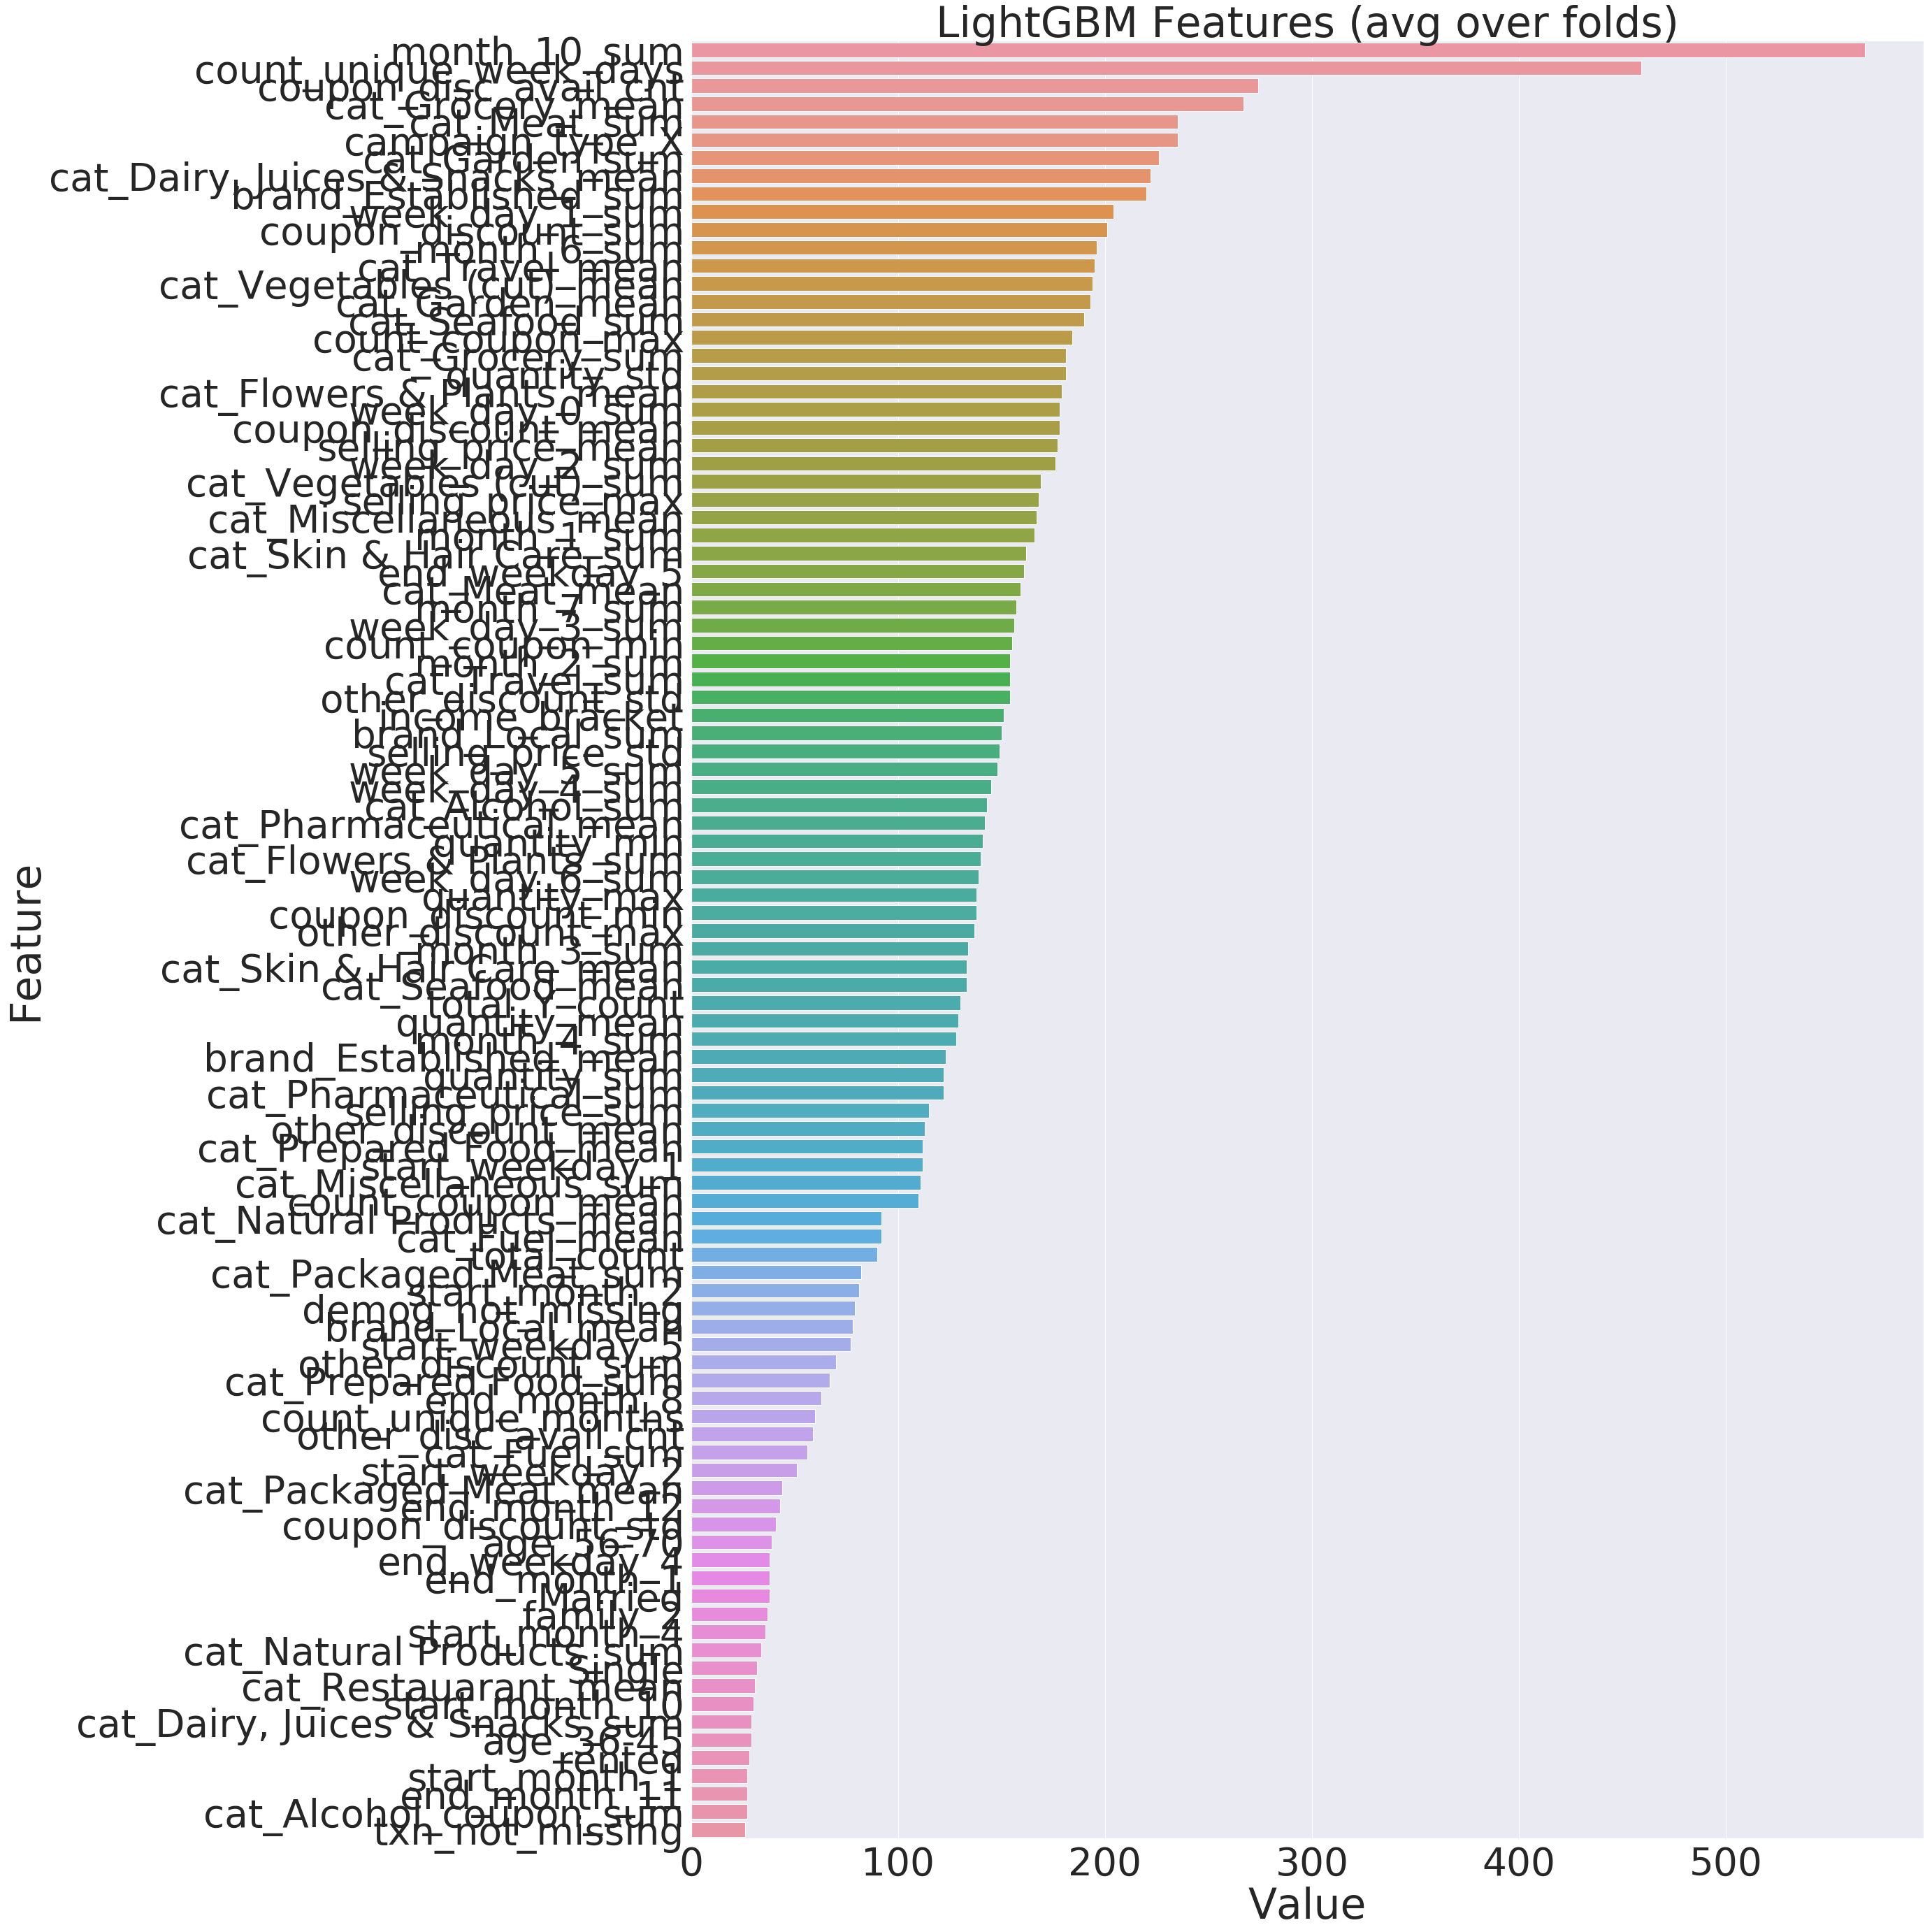

In [55]:
plt.figure(figsize=(40, 40))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:100])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [56]:
feature_imp[feature_imp['Value'] > 5 ]

,Value,Feature
27,6,family_4
28,7,campaign_type_Y
29,7,month_8_sum
30,7,month_9_sum
31,8,cat_Restauarant_sum
...,...,...
145,235,cat_Meat_sum
146,267,cat_Grocery_mean
147,274,coupon_disc_avail_cnt
148,459,count_unique_week_days


In [57]:
feature_imp[feature_imp['Value'] < 5 ]

,Value,Feature
0,0,cat_Alcohol_mean
1,0,cat_Bakery_sum
2,0,children_3+
3,0,count_unique_days
4,0,count_unique_weeks
5,0,coupon_brand_Established_count
6,0,end_month_10
7,0,end_month_4
8,0,end_month_5
9,0,end_month_7


In [58]:
# features_2 = (feature_imp['Feature'][feature_imp['Value'] > 0 ]).tolist()
# train_X = train_data_X[features_2]
# X4 = sc.fit_transform(train_X)
# X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size = 0.25, random_state = 2156)
# #training on complete set using lightgbm
# params = {}
# params = {'bagging_fraction': 0.7152640724930646,
#  'feature_fraction': 0.25413787367143803,
#  'lambda_l1': 0.3502680950883391,
#  'lambda_l2': 0.42137929665148266,
#  'learning_rate': 0.017100687927855764,
#  'max_bin': 49,
#  'max_depth': 6,
#  'min_data_in_leaf': 185,
#  'min_split_gain': 0.0029471188319716633,
#  'min_sum_hessian_in_leaf': 0.9222459426424153,
#  'num_leaves': 24}
# params["objective"] = "binary"
# params['metric'] = 'auc'
# # params['is_unbalance'] = 'true'
# # params['max_bin'] = 20
# params['random_state'] = 2156


# # params['device'] = 'gpu'

# num_rounds = 10000
# plst = list(params.items())
# lgtrain = lgb.Dataset(X_train, label = y_train)
# lgtest = lgb.Dataset(X_test, label = y_test)      

# model = lgb.train(params, lgtrain, num_rounds, valid_sets = [lgtrain,lgtest], early_stopping_rounds=200, verbose_eval=100)

# pred_lgb = model.predict(X_test, num_iteration=model.best_iteration)
# print(roc_auc_score(y_test, pred_lgb))

In [59]:
# lgb_cv_train = lgb.Dataset(X4, y)
# model_cv = lgb.cv(params, lgb_cv_train, num_rounds, nfold = 10, early_stopping_rounds=200, verbose_eval=100)

In [60]:
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

train_data_tune = lgb_cv_train
n_folds = 10
random_seed = 2156
init_round = 3
opt_round = 20
num_rounds = 4000
early_stopping_round = 100

def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_sum_hessian_in_leaf, min_data_in_leaf, learning_rate, max_bin, scale_pos_weight):
    params = {'application':'binary', 'early_stopping_round': 200, 'metric':'auc'}
    
    params["num_leaves"] = int(num_leaves)
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['learning_rate'] = learning_rate
    params['min_data_in_leaf'] = int(min_data_in_leaf)
    params['max_bin'] = int(max_bin)
    params['scale_pos_weight'] = scale_pos_weight
    cv_result = lgb.cv(params, train_data_tune, num_rounds, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
    return max(cv_result['auc-mean'])

lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (15, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.5, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 1),
                                        'lambda_l2': (2, 5),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_sum_hessian_in_leaf': (0.1, 50),
                                        'min_data_in_leaf' : (100, 200),
                                        'learning_rate' : (0.005, 0.05),
                                        'max_bin' : (20, 50),
                                        'scale_pos_weight' : (1, 10)}, 
                             random_state = 2156)

# lgbBO.maximize(init_points = init_round, n_iter = opt_round)

In [61]:
print(lgbBO.max)


{}


In [62]:
lgbBO.max['params']

KeyError: 'params'

After removing correlated vars :
{'bagging_fraction': 0.7152640724930646,
 'feature_fraction': 0.25413787367143803,
 'lambda_l1': 0.3502680950883391,
 'lambda_l2': 0.42137929665148266,
 'learning_rate': 0.017100687927855764,
 'max_bin': 48.76701604303327,
 'max_depth': 8.368203231266925,
 'min_data_in_leaf': 185.3919299686175,
 'min_split_gain': 0.0029471188319716633,
 'min_sum_hessian_in_leaf': 0.9222459426424153,
 'num_leaves': 44.198496573778314}

{'target': 0.9403134341400854, 'params': {'bagging_fraction': 0.7152640724930646, 'feature_fraction': 0.25413787367143803, 'lambda_l1': 0.3502680950883391, 'lambda_l2': 0.42137929665148266, 'learning_rate': 0.017100687927855764, 'max_bin': 48.76701604303327, 'max_depth': 8.368203231266925, 'min_data_in_leaf': 185.3919299686175, 'min_split_gain': 0.0029471188319716633, 'min_sum_hessian_in_leaf': 0.9222459426424153, 'num_leaves': 44.198496573778314}}

{'target': 0.9148305814919109, 'params': {'bagging_fraction': 0.7012464688754839, 'feature_fraction': 0.31394833217518725, 'lambda_l1': 1.3177261689323698, 'lambda_l2': 0.9898511983583828, 'learning_rate': 0.02626369826614482, 'max_depth': 6.287651457570486, 'min_data_in_leaf': 156.2892388288297, 'min_split_gain': 0.01518343437519875, 'min_sum_hessian_in_leaf': 5.082455745769561, 'num_leaves': 17.209365811546412}}

{'target': 0.9132174303678454, 'params': {'bagging_fraction': 0.8465721773904149, 'feature_fraction': 0.24217142061087804, 'lambda_l1': 3.8548373467112285, 'lambda_l2': 2.9959784385766963, 'learning_rate': 0.03265332968567199, 'max_depth': 7.252573057127469, 'min_data_in_leaf': 161.2334573909448, 'min_split_gain': 0.0022443641491280706, 'min_sum_hessian_in_leaf': 29.524442377213752, 'num_leaves': 21.018597490155827}}

In [63]:
# #training on complete data set using logistic

# clf = LogisticRegression(random_state = 223, solver='newton-cg',max_iter = 5000, C = 0.75, dual = False).fit(X_r2, y_r2)

# # lg_train = lgb.Dataset(X_r2, label = y_r2)
# # lgb_model = lgb.train(params, lg_train, num_rounds)

In [64]:
#training on complete set using lightgbm
params = {}
params = {'bagging_fraction': 0.7152640724930646,
 'feature_fraction': 0.25413787367143803,
 'scale_pos_weight' : 3.5,
 'lambda_l1': 0.2,
 'lambda_l2': 4.5,
 'learning_rate': 0.017100687927855764,
 'max_bin': 45,
 'max_depth': 8,
 'min_data_in_leaf': 185,
 'min_split_gain': 0.0029471188319716633,
 'min_sum_hessian_in_leaf': 0.9222459426424153,
 'num_leaves': 30}
params["objective"] = "binary"
params['metric'] = 'auc'
# params['is_unbalance'] = 'true'
# params['max_bin'] = 20
params['random_state'] = 2156

# params['device'] = 'gpu'

num_rounds = 1100
plst = list(params.items())

lgtrain_full = lgb.Dataset(X3, label = y)

model_full = lgb.train(params, lgtrain_full, num_rounds, verbose_eval = -1)

In [65]:
# from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
# def display_scores(scores):
#     print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
    
# def report_best_scores(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")
# clf_reg = LogisticRegression(random_state=170, solver='lbfgs',max_iter = 500)
# scores = cross_val_score(clf_reg, X_r2, y_r2, scoring="roc_auc", cv=10, verbose = 1)
# display_scores(scores)

In [66]:
# def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None): 
#     params = {}
#     params["objective"] = "binary"
#     params['metric'] = 'auc'
#     params["max_depth"] = 8    
#     params["min_data_in_leaf"] = 1
#     params["learning_rate"] = 0.01
#     params["bagging_fraction"] = 0.7
#     params["feature_fraction"] = 0.7
#     params["bagging_freq"] = 1
#     params["bagging_seed"] = 0
#     params["verbosity"] = 1
#     num_rounds = 20000
#     plst = list(params.items())
#     lgtrain = lgb.Dataset(train_X, label=train_y)
    
#     if test_y is not None:        
#         lgtest = lgb.Dataset(test_X, label=test_y)        
#         model = lgb.train(params, lgtrain,num_rounds,valid_sets=[lgtrain,lgtest],early_stopping_rounds=100, verbose_eval=500)

#     else:
#         lgtest = lgb.Dataset(test_X)
#         model = lgb.train(params, lgtrain,num_rounds)
        
#     pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
#     pred_test_y = (pred_test_y)      

#     loss = 0
#     if test_y is not None:           
#         loss = roc_auc_score((test_y), pred_test_y)        
#         return pred_test_y, loss, model
#     else:
#         return pred_test_y, loss, model
    
# cv_scores = []
# pred_test_full = 0
# kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=128900)

# for dev_index, val_index in kf.split(X, y):    
#     dev_X, val_X = train_X[dev_index], train_X[val_index]
#     dev_y, val_y = train_Y[dev_index], train_Y[val_index]    
#     print(dev_X.shape)
#     print(dev_y.shape)
#     print(val_X.shape)
#     print(val_y.shape)
#     pred_val, loss,model = runLGB(dev_X, dev_y, val_X, val_y)
#     pred_test_full += pred_val
#     cv_scores.append(loss)
#     print(cv_scores)
# pred_test_full /= 5.
# print(sum(cv_scores)/5)

In [67]:
type(X)

pandas.core.frame.DataFrame

In [68]:
train_X.shape

(78369, 150)

## **Test Data**

In [69]:
# test_data = pd.read_csv('test_data.csv')
# test_data.describe(include = 'all')
# test_data.nunique()

In [70]:
(test_data.groupby(['customer_id', 'coupon_id'], as_index = False).campaign_id.count()).quantile([0, 0.25, 0.5, 0.75, 0.99, 0.9998, 1])

,customer_id,coupon_id,campaign_id
0.0000,1.0,28.0,1.0000
0.2500,432.0,264.0,1.0000
0.5000,827.0,590.0,1.0000
0.7500,1209.0,853.0,1.0000
0.9900,1571.0,1109.0,2.0000
0.9998,1582.0,1116.0,2.0704
1.0000,1582.0,1116.0,3.0000


In [71]:
test_data_2 = pd.merge(test_data, customer_demog_data_2, on = 'customer_id', how = 'left')
test_data_2 = pd.merge(test_data_2, campaign_data_6, on = 'campaign_id', how = 'left')
test_data_2 = pd.merge(test_data_2, transaction_summary_sub, on = ['customer_id'], how = 'left')
test_data_2 = pd.merge(test_data_2, coupon_item_data_3, on = 'coupon_id', how = 'left')

test_data_2['demog_not_missing'].fillna(0, inplace = True)
test_data_2['txn_not_missing'].fillna(0, inplace = True)

test_data_2 = test_data_2.reset_index()

test_data_X = test_data_2.drop(['index', 'id', 'campaign_id','customer_id','coupon_id'], axis = 1)

test_data_X2 = test_data_X[features]

print(test_data_X.shape)
print(test_data_X2.shape)

# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# imp.fit(test_data_X)
# X = imp.transform(test_data_X)

from sklearn.preprocessing import StandardScaler
sc = RobustScaler()
test_X = sc.fit_transform(test_data_X2)

X1 = test_X
# pred = model.predict_proba(X1)[:,1]
pred = model_full.predict(X1)



(50226, 169)
(50226, 150)


In [72]:
test_data_2.shape

(50226, 174)

In [73]:
test_data_2.txn_not_missing.value_counts()

1    50226
Name: txn_not_missing, dtype: int64

In [74]:
test_data_2.groupby(['demog_not_missing','txn_not_missing'], as_index = False)[['customer_id','coupon_id']].count()

,demog_not_missing,txn_not_missing,customer_id,coupon_id
0,0.0,1,19287,19287
1,1.0,1,30939,30939


In [75]:
submit_data = pd.DataFrame()
submit_data['id'] = test_data['id']
submit_data['redemption_status'] = pred
submit_data.head(5)

,id,redemption_status
0,3,0.136781
1,4,0.001705
2,5,0.059254
3,8,0.004418
4,10,0.001350


In [76]:
submit_data.columns

Index(['id', 'redemption_status'], dtype='object')

In [77]:
print(min(submit_data.redemption_status))
print(max(submit_data.redemption_status))

3.4830816917809376e-06
0.8280100881813143


In [78]:
submit_data.to_csv('submit_lgbm_8.csv',index = False)